# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download(['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger'])

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df['email'].value_counts().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

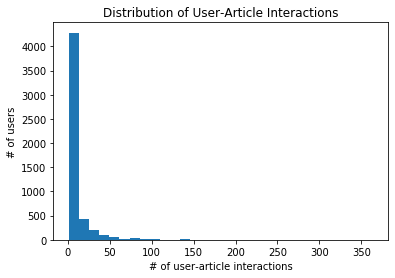

In [4]:
plt.hist(df['email'].value_counts(), bins=30)
plt.title('Distribution of User-Article Interactions')
plt.xlabel('# of user-article interactions')
plt.ylabel('# of users')
plt.show()

In [5]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
df_content.shape

(1056, 5)

In [7]:
# Find and explore duplicate articles
df_content[df_content['article_id'].duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [8]:
df_content.nunique()

doc_body           1036
doc_description    1022
doc_full_name      1051
doc_status            1
article_id         1051
dtype: int64

In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)

In [10]:
# Check shape again (will give answer to question-b below)
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
# unique values in each column in df (will give answer to question-a and question-c below)
df.nunique()

article_id     714
title          714
email         5148
dtype: int64

In [12]:
# number of interactions (will give answer to question-d below)
df.shape

(45993, 3)

In [13]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [14]:
df['article_id'].value_counts(ascending=False)

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
         ... 
974.0       1
417.0       1
1113.0      1
984.0       1
1072.0      1
Name: article_id, Length: 714, dtype: int64

In [15]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [16]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [17]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [18]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_list = list(df['title'].value_counts(ascending=False).index)
    top_articles = top_list[:n]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_list = list(df['article_id'].value_counts(ascending=False).index)
    top_articles = top_list[:n]
 
    return top_articles # Return the top article ids

In [19]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [20]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [21]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = (df.groupby(['user_id', 'article_id']).count()>0).astype(int)
    user_item = user_item.unstack()
    user_item.fillna(0, inplace=True)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [22]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [23]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # My original way to solve it using looping
    # compute similarity of each user to the provided user
    # user_item_row = user_item.loc[user_id]
    # similarity_dict = {}
    # for user in list(user_item.index):
    #    score = np.dot(user_item_row, user_item.loc[user])
    #    similarity_dict[user] = score
    # sort by similarity
    # sorted_similarity_dict = sorted(similarity_dict.items(), key = lambda x:x[1], reverse=True)
    # create list of just the ids
    # most_similar_users = [item[0] for item in sorted_similarity_dict]
    
    # Suggested way using the dot product on the metrix
    # compute similarity of each user to the provided user
    similar_mat = user_item.dot(user_item.loc[user_id].T)
    # sort by similarity
    most_similar_users = similar_mat.sort_values(ascending=False).index.tolist()
    
    
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [24]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [25]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = list(df[df['article_id'].isin(article_ids)]['title'].drop_duplicates())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = [str(article_id) for article_id in list(user_item.loc[user_id][user_item.loc[user_id]==1].title.index)]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    seen_article_id, seen_article_name = get_user_articles(user_id)
    recs = []
    
    for user in similar_users:
        new_article_id, new_article_name = get_user_articles(user)
        not_seen_article_id = list(set(new_article_id) - set(seen_article_id) - set(recs))
        n_to_be_added = m - len(recs) # num of articles to-be-added so that we can reach m
        
        if len(not_seen_article_id) >= n_to_be_added:
            recs.extend(not_seen_article_id[:n_to_be_added])
            break
        else:
            recs.extend(not_seen_article_id)   
    
    return recs # return your recommendations for this user_id    

In [26]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['visualize data with the matplotlib library',
 'better together: spss and data science experience',
 'times world university ranking analysis',
 'brunel 2.0 preview',
 'pixiedust 1.0 is here! – ibm watson data lab',
 'higher-order logistic regression for large datasets',
 'a dynamic duo – inside machine learning – medium',
 'airbnb data for analytics: vancouver listings',
 'using rstudio in ibm data science experience',
 'get started with streams designer by following this roadmap']

In [27]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [28]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    # Note: This is a revised version of the original function (given below as "get_top_sorted_users_loop")
    #       In this revised version, I replaced the loop with dot product on the matrix, and also 
    #       simplified the construction of the output dataframe.
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # calculate the similarity by dot product and rank users by how many interactions they have
    similar_mat = user_item.dot(user_item.loc[user_id].T)
    top_user_ids = df['user_id'].value_counts(ascending=True)
    
    # create output dataframe
    frame = { 'similarity': similar_mat, 'num_interactions': top_user_ids } 
    neighbors_df = pd.DataFrame(frame)

    # sort by similarity then num of interactions
    neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=False, inplace=True)
    # drop the user of interest from the dataframe 
    neighbors_df.drop(index=user_id, inplace=True)
    # reset index and rename the user_id column into neighbor_id
    neighbors_df.reset_index(inplace=True)
    neighbors_df.rename(columns={'index': 'neighbor_id'}, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [31]:
def get_top_sorted_users_loop(user_id, df=df, user_item=user_item):
    # Note: This is version 1 of this function, in which I used a loop to calculate the similarity between users.
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # compute similarity of each user to the provided user and include the rank for the other users based on interactions
    user_item_row = user_item.loc[user_id]
    similarity_dict = {}
    top_user_ids = df['user_id'].value_counts(ascending=True)
    for user in list(user_item.index):
        score = np.dot(user_item_row, user_item.loc[user])
        rank = list(top_user_ids.index).index(user)
        similarity_dict[user] = [score,rank]
    
    # create output dataframe
    neighbors_df = pd.DataFrame.from_dict(similarity_dict, orient='index', columns=['similarity', 'num_interactions'])
    # drop the user of interest from the dataframe
    neighbors_df.drop(index=user_id, inplace=True)
    # sort by similarity first and then by num of interactions
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    # reset index and name the user_id column
    neighbors_df.reset_index(inplace=True)
    neighbors_df.rename(columns={'index': 'neighbor_id'}, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
    '''
    similar_users = list(get_top_sorted_users(user_id)['neighbor_id'])
    seen_article_id, seen_article_name = get_user_articles(user_id)
    popular_articles_df = popular_articles() # use the function I wrote below to generate a dataframe of article with num of views sorted from most views to least views
    recs = []
    
    for user in similar_users:
        new_article_id, new_article_name = get_user_articles(user)
        not_seen_article_id = list(set(new_article_id) - set(seen_article_id) - set(recs))
        n_to_be_added = m - len(recs) # num of articles to-be-added so that we can reach m
        
        if len(not_seen_article_id) >= n_to_be_added:
            not_seen_article_sorted = list(popular_articles_df[popular_articles_df['article_id'].isin(not_seen_article_id)]['article_id'])
            recs.extend(not_seen_article_sorted[:n_to_be_added])
            break
        else:
            recs.extend(not_seen_article_id)
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [32]:
def popular_articles(df=df):
    '''
    INPUT:
    df - (pandas dataframe) df as defined at the top of the notebook 
            
    OUTPUT:
    popular_df - (pandas dataframe) a dataframe with:
                    article_id - is a neighbor user_id
                    num_views - the number of users who viewed this article
                    
    Description:
    Provides a dataframe of the article_ids and its num of views, sorted from most popular (most views) to the least popular
    '''
    # sort articles by num of views (descending)
    popular_articles_df = pd.DataFrame(df['article_id'].value_counts(ascending=False))
    # reset index and rename columns
    popular_articles_df.reset_index(inplace=True)
    popular_articles_df.rename(columns={'article_id': 'num_views', 'index': 'article_id'}, inplace=True)
    
    return popular_articles_df

In [33]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [34]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id'] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9]['neighbor_id'] # Find the 10th most similar user to user 131

In [35]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

-- The "get_top_article_ids" function will be useful, because we don't know anything about this new user, we would want to start with recommending the most popular articles on our site. (Similarly we can also use the function "popular_articles" that I wrote, which create a dataframe with articles sorted from most popular to least popular -- I wrote it so that my "user_user_recs_part2" function can be simplier.)  
  
-- We know that knowledge-based and content-based recommendations are needed for cold-start problems. So here, I think a better way may be asking the new user with survey questions to find out the areas that he/she is interested in, and then recommend articles in those area first. For example, if a new user indicates that he/she is interested in machine learning, we can start with recommending popular articles with "machine learning" in the title. 

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [36]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(article_id) for article_id in get_top_article_ids(10)] # Your recommendations here
# Note: in order to pass the test below, I changed the type of article_id from float to string


In [37]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

First, let's review the two dataframes and to decide which part of the content to be analyzed. 

In [88]:
df.nunique()

article_id     714
title          714
user_id       5149
dtype: int64

In [38]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [80]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


The two dataframes I am working on in this project are "df" and "df_content", where "df" contains the information of user-item interaction and "df_contennt" contains more detailed information of each article (article title, description, and body text. However, during this analysis, I found that several articles in "df" dataframe are not included in the "df_content" dataframe. To make sure we give an accurate and complete recommendation, I will first merge the two dataframes to get a complete list of articles, then analyze the title of each article for content-based recommendation. 

In [109]:
# select the article_id and title (or doc_full_name) columns in df and df_content dataframes, 
# rename the "doc_full_name" column to "title" to be consistent
df1 = df[['article_id', 'title']]
df2 = df_content[['article_id', 'doc_full_name']]
df2.rename(columns={'doc_full_name':'title'}, inplace=True)

/Users/zhaoli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [113]:
# merge the two dataframes and ddrop the duplicated rows to create a complete set of articles
df_merged = pd.concat([df1, df2], ignore_index=True)
df_merged.drop_duplicates(subset=['article_id'], inplace=True)
df_merged.sort_values(by='article_id', inplace=True)
df_merged.reset_index(drop=True, inplace=True)
df_merged.head()

,article_id,title
0,0.0,detect malfunctioning iot sensors with streami...
1,1.0,Communicating data science: A guide to present...
2,2.0,"this week in data science (april 18, 2017)"
3,3.0,DataLayer Conference: Boost the performance of...
4,4.0,analyze ny restaurant data using spark in dsx


Now let's define the tokenize function, and then use TF-IDF to vectorize the title of each article:

In [474]:
def tokenize(text):
    '''
    INPUT:
    text - (str) the text to be tokenized    
    OUTPUT:
    tokens - (list) a list of tokens for the input text
    
    Description:
    Tokenize the input text and return the tokens
    '''
    # normalize case and remove punctuation
    #text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # tokenize text
    tokens = word_tokenize(text)

    # lemmatize and remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # remove short words (otherwise there will be error message during tf-idf)
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

In [272]:
# initialize tf-idf vectorizer object
vect = TfidfVectorizer(tokenizer=tokenize, stop_words='english', use_idf=True)
# compute bag of word counts and tf-idf values, and connvert sparse matrix to numpy array, then pd dataframe
df_vect = pd.DataFrame(vect.fit_transform(df_merged['title'].values).toarray(), columns=[*vect.vocabulary_])
# concat  df_total and df_vec
df_tfidf = pd.concat([df_merged, df_vect], axis=1)

Now I need to find similar articles based on the vectorization result and dot product:

In [477]:
def get_similar_articles(article_id, df_tfidf=df_tfidf):
    '''
    INPUT:
    article_id - (int)
    df_tfidf - (pandas dataframe) dataframe after tfidf; columns: article_id, title, and all tokens 
            
    OUTPUT:
    similar_df - (pandas dataframe) a dataframe with:
                    sim_article_id - is the article_id of the similar articles (sorted by similarity higher to lower)
                    similarity - measure of the similarity of each article to the provided article_id
    Description:
    For a given article_id of interest, use dot product of the TF-IDF matrix 
    to sort the rest articles from most similar to least similar
    '''
    # build a temp df with all tokens and set the index as article_id 
    df_temp = df_tfidf.copy()
    df_temp.drop(columns=['title'], inplace=True)
    df_temp.set_index('article_id', inplace=True)
    
    # calculate the similarity by dot product (how similar other articles are to the input article_id)
    similar_mat = df_temp.dot(df_temp.loc[article_id].T)
    
    # create output dataframe
    frame = { 'similarity': similar_mat } 
    similar_df = pd.DataFrame(frame)

    # sort by similarity
    similar_df.sort_values(by=['similarity'],ascending=False, inplace=True)
    # drop the article of interest from the dataframe 
    similar_df.drop(index=article_id, inplace=True)
    # reset index and rename the article_id column into sim_article_id
    similar_df.reset_index(inplace=True)
    similar_df.rename(columns={'index': 'sim_article_id'}, inplace=True)
    
    return similar_df # Return the dataframe specified in the doc_string

In [481]:
def collect_similar_articles(article_id, threshold=0.5):
    '''
    INPUT:
    article_id - (int)
    threshold - (float) threshold similarity value; if the similarity of an article is above threshold, 
                it will be included in the "most_similar_article" list in the output
            
    OUTPUT:
    most_similar_article - (pandas dataframe) a dataframe of the most similar articles:
                    article_id - is the article_id of the similar articles (sorted by similarity higher to lower)
                    similarity - measure of the similarity of each article to the provided article_id
    Description:
    For a given article_id of interest, get the similar article dataframe using "get_similar_articles" function above
    and return a truncated dataframe of articles with similarity higher than the threshold
    '''
    temp = get_similar_articles(article_id, df_tfidf=df_tfidf)
    most_similar_article = temp[temp['similarity']>=threshold]
    
    return most_similar_article # Return the dataframe specified in the doc_string

def content_based_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    rec_article_id - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    First get the articles that the user of interest have seen;
    Then collect the similar articles to each seen article;
    Remove the seen articles from the collect,
    and return the top m not-seen articles to the user (based on the similarity)
    
    Notes:
    * Now the only creteria is the similarity value, 
    it can be considered to add a new column for popularity: use "popular_articles()" function defined above
    
    * In addition, it can also be considered to increase weighting of the new articles that are similar to 
    more than 1 seen article
    '''
    # articles that have been read by the user of interest
    seen_article_id, seen_article_name = get_user_articles(user_id)
    
    # collect the similar articles to the seen articles
    thr = 0.7
    while thr >= 0:
        pool = pd.DataFrame([])
        for article_id in seen_article_id:
            current = collect_similar_articles(float(article_id), threshold=thr)
            pool = pd.concat([pool, current])
        pool.sort_values('similarity', ascending=False, inplace=True)
        pool_unique = pool.drop_duplicates(subset=['article_id'])
    
        new_article_id = list(pool_unique['article_id'])
        not_seen_article_id = list(set(new_article_id) - set(list(np.float_(seen_article_id))))
        
        if len(not_seen_article_id) >= m:
            break
        thr -= 0.1
    
    # remove the seen articles from the collection, and return the unseen, recommended articles
    pool_not_seen = pool_unique[~pool_unique['article_id'].isin(seen_article_id)]
    rec_article_id = list(pool_not_seen.reset_index().loc[:(m-1)]['article_id'])
    rec_names = get_article_names(rec_article_id, df_merged)
    
    return rec_article_id, rec_names

Here let's use user 2 and user 1234 as tests:

In [495]:
print('The articles user 2 have read: ')
print(get_user_articles(2))
print('The top 10 articles my content-based engine recommends to user 2: ')
print(content_based_recs(2, 10))

The articles user 2 have read: 
(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'], ['healthcare python streaming application demo', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for naive bayes model', 'use r dataframes & ibm watson natural language understanding', 'build a python app on the streaming analytics service', 'using deep learning to reconstruct high-resolution audio'])
The top 10 articles my content-based engine recommends to user 2: 
([1304.0, 1274.0, 470.0, 555.0, 124.0, 730.0, 52.0, 1047.0, 437.0, 809.0], ['Build an app using IBM Graph', 'python machine learning: scikit-learn tutorial', 'ibm watson machine learning: get started', 'what’s new in the streaming analytics service on bluemix', 'build a naive-bayes model with wml & dsx', 'developing for the ibm streaming analytics service', 'use the machine learning library', 'a comparison of logistic regression and naive bayes ', 'data model with streaming analytics and pyth

The articles that user 2 have read are related to topics like python, machine learning models, deep learning, and apps, which are consistent with the new articles recommended by my content-based rec engine.

In [496]:
print('The articles user 1234 have read: ')
print(get_user_articles(1234))
print('The top 10 articles my content-based engine recommends to user 1234: ')
print(content_based_recs(1234, 10))

The articles user 1234 have read: 
(['39.0', '415.0', '730.0', '1060.0', '1304.0', '1305.0', '1330.0', '1391.0', '1424.0'], ['gosales transactions for naive bayes model', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'developing for the ibm streaming analytics service', 'airbnb data for analytics: amsterdam listings', 'sudoku', 'using machine learning to predict value of homes on airbnb', 'use spark for python to load data and run sql queries', 'pulling and displaying etf data'])
The top 10 articles my content-based engine recommends to user 1234: 
([1425.0, 1426.0, 1061.0, 1059.0, 470.0, 1063.0, 1085.0, 1124.0, 1139.0, 1073.0], ['what’s new in the streaming analytics service on bluemix', 'airbnb data for analytics: amsterdam calendar', 'airbnb data for analytics: amsterdam reviews', 'airbnb data for analytics: antwerp listings', 'airbnb data for analytics: barcelona listings', 'airbnb data for analytics: chicago listings', 'airbnb

The articles that user 1234 have read are related to topics like python, machine learning models, airbnb, and sql, which are also consistent with the new articles recommended by my content-based rec engine.

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In Part IV I built a content-based recommendation engine, in which I used the natural language processing (NLP) technics and dot product of the vectorization matrix to find similarities between articles based on their titles. According to the tests, my content-based rec engine works very well to recommend new articles to a user based on the ones he/she has viewed.  
  
Future improvements:  
(1) Here the "content" I used is the "title" of the article (or "doc_full_name" in the df_content dataframe). This is because all articles have their titles (i.e., there is no NaN values in this column) and most of time the title gives a good one-sentence summary of the article. I do think that for an articles with description, its description can be used as content to make my content-based recommendation more accurate.  
(2) Currently the only creteria is the similarity value, a future improvement can be adding a new column for popularity; if two articles have same similarity values to a seen article, we will recommend the more popular article first. In addition, it can also be considered to increase weighting of the new articles that are similar to more than 1 seen article.  
(3) Because the data I am given in this project only have information of which articles have been viewed; if further information like how long the user spent in viewing an article and/or the rate a user rates for an article, these additional pieces of information can also be included in weighting of the new articles. 

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [96]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [97]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [98]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [99]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

In the lesson, we were working on a movie rating system, and therefore the user_item_matrix contains the rating that each user gives to each movie that he/she watched and NaN otherwise. In this project, we only consider whether a user viewed an article or not, and our user_item_matrix contains binary values with a "0" representing non-interaction (not viewed) and a "1" representing interaction (viewed); there is no missing values here. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

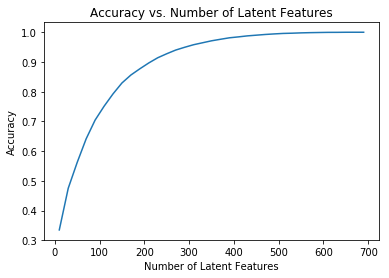

In [104]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

Because we will do a similar estimation and plot later for our test set, I decide to make this code into a function:

In [105]:
def plot_accuracy_latent_features(s, u, vt, user_item_matrix, n_min=10, n_max=710, n_step=20, common_idx=[], common_arts=[], user_item_test=[]):
    
    '''
    INPUT:
    s, u, vt - (np array) 2-D matrices generated in SVD 
    user_item_matrix - (pandas dataframe) with users in the index and items in the column, showing the interactions between users and items
    n_min, n_max, n_step - (int) the lower and upper bound of the latent features, and the step between the two bounds
    common_idx, commonn_arts - [optional] (np array) arrays showing the common users/items between train and test sets (only when we study the test set)
    user_item_test - [optional] (pandas dataframe) user_item_matrix for the test set (only when we study the test set) 
    
    OUTPUT:
    None
                    
    Description:
    Calculate and plot how accuracy changes with the number of latent features in SVD
    '''
    
    num_latent_feats = np.arange(n_min, n_max, n_step)
    sum_errs = []
    if len(user_item_test)>0: # calculate accuracy for test set
        u_test = u_train[common_idx, :]
        vt_test = vt_train[:, common_arts]
        user_item_test = user_item_test.loc[common_idx,common_arts]
        err_denominator = user_item_test.shape[0]*user_item_test.shape[1] # will be used in accuracy calcaulation
    else:
        err_denominator = user_item_matrix.shape[0]*user_item_matrix.shape[1] # will be used in accuracy calcaulation
    
    for k in num_latent_feats:
        # restructure with k latent features
        s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
        
        if len(user_item_test)>0: # calculate accuracy for test set
            
            u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
            
            # take dot product
            user_item_est = np.around(np.dot(np.dot(u_test_new, s_new), vt_test_new))
            
            # compute error for each prediction to actual value
            diffs = np.subtract(user_item_test, user_item_est) 
        
        else: # calculate accuracy for train set
            
            # take dot product 
            user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
            # compute error for each prediction to actual value
            diffs = np.subtract(user_item_matrix, user_item_est) 
        
        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)
    
    
    #plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
    plt.plot(num_latent_feats, 1 - np.array(sum_errs)/err_denominator);
    plt.xlabel('Number of Latent Features');
    plt.ylabel('Accuracy');
    plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [106]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # create user_item matrix for the train set
    user_item_train = create_user_item_matrix(df_train)
    # create user_item matrix for the test set
    user_item_test = create_user_item_matrix(df_test)
    
    # user_id and article_id are the index and column of the user_item_test dataframe that we just created
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [107]:
user_item_train.shape, user_item_test.shape, len(test_idx), len(test_arts)

((4487, 714), (682, 574), 682, 574)

In [108]:
user_item_test.head()

title                                                          \
article_id 0.0    2.0    4.0    8.0    9.0    12.0   14.0   15.0   16.0     
user_id                                                                     
2917          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3024          0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
3093          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3193          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3527          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                   ...                                                     \
article_id 18.0    ...   1432.0 1433.0 1434.0 1435.0 1436.0 1437.0 1439.0   
user_id            ...                                                      
2917          0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3024          0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3093          0.0  ...      0.0    0.0    0.0    0.0    1.0    0.0    0.0   
3193          0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3527          0.0  ...      0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                                 
article_id 1440.0 1441.0 1443.0  
user_id                          
2917          0.0    0.0    0.0  
3024          0.0    0.0    0.0  
3093          0.0    0.0    0.0  
3193          0.0    0.0    0.0  
3527          0.0    0.0    0.0  

[5 rows x 574 columns]

In [109]:
# How many users can we make predictions for in the test set?
train_idx = list(user_item_train.index)
train_arts = list(user_item_train.title.columns)
n_test_in_train = user_item_test[user_item_test.index.isin(train_idx)].shape[0]
n_test_in_train

20

In [110]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
len(test_idx) - n_test_in_train

662

In [111]:
# How many movies can we make predictions for in the test set?
n_art_test_in_train = len(user_item_test.title.columns.isin(train_arts))
n_art_test_in_train

574

In [112]:
# How many movies in the test set are we not able to make predictions for because of the cold start problem?
len(test_arts) - n_art_test_in_train

0

In [113]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many movies can we make predictions for in the test set?': b, # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [114]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [115]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [116]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [117]:
# Find the user_id and article_id that are shared between train and test sets
common_idx = user_item_test.index.isin(train_idx)
common_arts = user_item_test.title.columns.isin(train_arts)

Now use the function written above to estimate the accuracy of the test set and plot how accuracy changes with number of latent features.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4487 but corresponding boolean dimension is 682
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 714 but corresponding boolean dimension is 574


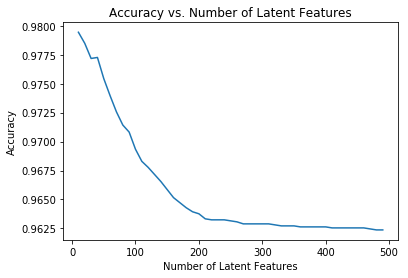

In [118]:
plot_accuracy_latent_features(s_train, u_train, vt_train, user_item_matrix, 10, 500, 10, common_idx, common_arts, user_item_test)

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

From the above plot, we found that the accuracy to estimate the test set decreases when the number of latent features increases. This makes sense, as increasing the number of latent features results in overfitting the train set. This is especially true in our case, since we only have 20 out of 682 users in the test set who are also in the train set. In this case, we may need to consider other recommendation techniques, such as knowledge-based and content-based recommendations.  


We can use A/B testing to determine the efficiency/accuracy of our recommendation engines. We would seperate our users into two equal-size groups by cookies, the control group are given the current recommendation mechanism, while the experiment group are given the purposed recommendation mechaninsm. We would then compare the number of recommended articles viewed by each user between the two groups to see if our purposed recommendation engine increase the number of views.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [119]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0